# Создание моделей рекомендаций тарифов для компании "Мегалайн" 
В нашем распоряжении данные о поведении клиентов, которые уже перешли на  тарифы "Смарт" и "Ультра". К ним относятся количество сделанных звонков, потраченных минут, сообщений и мегабайт, а также отметка о наименовании тарифа. На основании этих данных нам необходимо построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — мы её уже сделали.

Нам необходимо построить модель с максимально большим значением *accuracy*. 
    
    
____



В данном исследовании представлен процесс создания и проверки моделей машинного обучения в целях создания рекомендательной системы. Работа произведена в соответствии с инструкциями заказчика. Каждый значительный шаг сопровождается промежуточным, либо общим выводом.
    
____
    

    
Часть 1. Изучение общей информации о предоставленном датасете
    
1. Импорт необходимых библиотек для работы с данными, загрузка датасета
2. Изучение данных, получение общей информации
3. Оценка мультиколлинеарности признаков
4. Вывод

Часть 2. Создание моделей

1. Разделение датасета на выборки
2. Исследование моделей
3. Применение выводов оценки мультиколлинеарности
4. Применение кросс валидации
5. Вывод
    
Часть 3. Проверка моделей на адекватность
    
1. Проверка моделей на адекватность
2. Вывод
    
Часть 4. Общий вывод
1. Общий вывод о проделанной работе

 ## Часть 1. Изучение общей информации о предоставленном датасете

<a id='Импорт необходимых библиотек для работы с данными, загрузка датасета'>

## <p style="text-align:center"> Импорт необходимых библиотек для работы с данными, загрузка датасета</p>

Импортируем необходимые библиотеки, убираем ограничения на количество столбцов, отключаем предупреждения.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import timeit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from IPython.display import display
pd.options.display.max_columns = None
import warnings
warnings.simplefilter('ignore')

Загружаем датасет, проверяем вывод.

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


<a id='Изучение данных, получение общей информации'></a>

## <p style="text-align:center"> Изучение данных, получение общей информации</p>

Ознакомимся с информацией, посмотрим соответствуют ли типы ячеек назначению. В качестве дополнительной проверки возьмем случайные 20 строк из нашего датасета, посмотрим на странные, выбивающиеся, отсутствующие значения. Так как датасет предобработан, ничего подохрительного мы увидеть не должны.

In [4]:
df.sample(n=20, random_state=1)

,calls,minutes,messages,mb_used,is_ultra
1719,62.0,545.53,3.0,4942.50,0
2922,74.0,498.09,97.0,16471.48,0
1895,93.0,630.74,54.0,13246.51,0
161,58.0,394.15,48.0,15605.44,0
255,40.0,225.89,12.0,13581.94,0
1089,51.0,371.83,63.0,5774.98,0
1463,7.0,22.96,7.0,12762.99,0
1009,84.0,608.19,19.0,25013.18,0
2322,134.0,933.89,91.0,12468.87,1
1126,93.0,628.59,41.0,19309.71,0


Иногда в таблицах в конце есть строка "Итого"(или т.п.), нам она не нужна, убедимся в ее отсутствии.

In [5]:
df.tail()

,calls,minutes,messages,mb_used,is_ultra
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0
3213,80.0,566.09,6.0,29480.52,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [7]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


<a id='Оценка мультиколлинеарности признаков'></a>

## <p style="text-align:center"> Оценка мультиколлинеарности признаков </p>

В качестве оценки мультиколлинеарности признаков найдем коффициенты корреляции этих признаков, если зависимость сильнее 0.7 попытаемся оставить только один признак из двух; также построим scatterplot для каждой зависимости.

In [8]:
df[['calls', 'minutes', 'messages', 'mb_used']].corr()

,calls,minutes,messages,mb_used
calls,1.000000,0.982083,0.177385,0.286442
minutes,0.982083,1.000000,0.173110,0.280967
messages,0.177385,0.173110,1.000000,0.195721
mb_used,0.286442,0.280967,0.195721,1.000000


На этом этапе можно увидеть сильную зависимость количества потраченных минут от количества произведенных звонков. Визуализируем данные для наглядности.

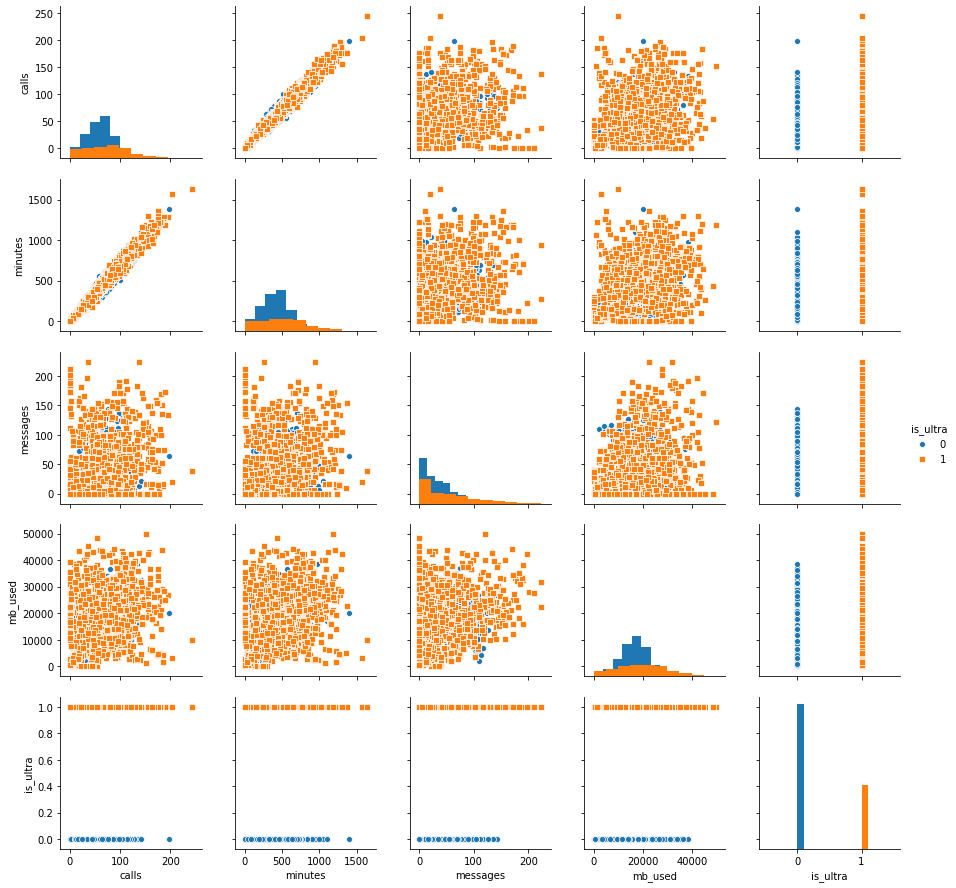

In [9]:
sns.pairplot(df, markers = ['o', 's'],  hue = 'is_ultra', diag_kind = 'hist');

Убедились в наличии линейной зависимости одних признаков, и в отсутствии этой зависимости у других. 

<a id='Вывод_1'></a>

## <p style="text-align:center"> Вывод</p>

##### В ходе первичного анализа данных были  сделаны следующие выводы:

___


1. Единственное к чему сразу цепляется глаз это тип данных float64, который потребляет больше памяти, чем uint16 и float32, которыми его можно заменить.


2. Обнаружили сильную линейную зависимость двух признаков. Попробуем разобраться с этим в следующей части нашего исследования.

___

Таким образом было выполнено первичное ознакомление с предоставленной информацией, дефекты датасета не выявлены. Данные не нуждаются в предобработке. Можно переходить к созданию моделей.

 ## Часть 2. Создание моделей

<a id='Разделение датасета на выборки'></a>

## <p style="text-align:center"> Разделение датасета на выборки </p>

Разделим исходный датасет на выборки: тренировочную, валидационную и тестовую. Три из пяти частей отдадим тренировочной выбрке, по одной части валидационной и тестовой.

In [10]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

In [11]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.4, random_state=42)
features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test, 
                                                                            test_size=0.5, random_state=42)

Проконтролируем разбиение выборок, используем для этого методы shape и len().

In [12]:
print(f'Размер тренировочной выборки: признаки - {features_train.shape} и целевой признак {len(target_train)}')

Размер тренировочной выборки: признаки - (1928, 4) и целевой признак 1928


In [13]:
print(f'Размер валидационной выборки: признаки - {features_valid.shape} и целевой признак {len(target_valid)}')

Размер валидационной выборки: признаки - (643, 4) и целевой признак 643


In [14]:
print(f'Размер тестовой выборки: признаки - {features_test.shape} и целевой признак {len(target_test)}')

Размер тестовой выборки: признаки - (643, 4) и целевой признак 643


<a id='Исследование моделей'></a>

## <p style="text-align:center"> Исследование моделей </p>

Ищем на сайте sklearn подходящие под задачу классификаторы. Выбираем нужные и настраиваем.

Для дальнейшего включения валидационной выборкам в обучение создадим дополнительные переменные.

In [15]:
all_features_train = pd.concat([features_train, features_valid], axis=0)
all_target_train = pd.concat([target_train, target_valid], axis=0)

### DecisionTreeClassifier или Дерево решений

In [16]:
start = timeit.default_timer()
best_model = None
best_result = 0
for depth in range(1, 6):
    for split in range (2, 17, 2):
        for leaf in range (1, 8):
            
            DTclf = DecisionTreeClassifier(random_state=42, max_depth=depth, min_samples_split=split, min_samples_leaf=leaf)
        
            DTclf.fit(features_train, target_train) 
        
            result = DTclf.score(features_valid, target_valid) 
    
            if result > best_result:
                best_model = DTclf
                best_result = result
stop = timeit.default_timer()
print("Accuracy of the best model, validation:", best_result)
print(f'Time spent: {stop - start:.2f} sec')

Accuracy of the best model, validation: 0.8118195956454122
Time spent: 1.84 sec


In [17]:
DTclf_score = DTclf.score(features_test, target_test)

In [18]:
print("Accuracy of the model, test:", DTclf_score)

Accuracy of the model, test: 0.776049766718507


In [19]:
DTclf_upd = DecisionTreeClassifier(random_state=42, max_depth=6, min_samples_split=2, min_samples_leaf=15)
DTclf_upd.fit(all_features_train, all_target_train);

In [20]:
DTclf_score_upd = DTclf_upd.score(features_test, target_test)

In [21]:
print("Accuracy of the best model, test:", DTclf_score_upd)

Accuracy of the best model, test: 0.7916018662519441


### RandomForestClassifier или Случайный лес

У случайного леса больше гиперпараметров для перебора, поэтому и работает он дольше.

In [22]:
start = timeit.default_timer()
best_model = None
best_result = 0
for est in range(10, 21, 10):
    for depth in range(1, 7):
        for leaf in range (1, 7):
            for split in range (2, 7, 2):
                
                RFclf = RandomForestClassifier(random_state=42, n_estimators=est, max_depth=depth, 
                                               min_samples_leaf=leaf, min_samples_split=split, n_jobs=-1) 
        
                RFclf.fit(features_train, target_train) 
        
                result = RFclf.score(features_valid, target_valid) 
                if result > best_result:
                    best_model = RFclf
                    best_result = result
stop = timeit.default_timer()
print("Accuracy of the best model, validation:", best_result)
print(f'Time spent: {stop - start:.2f} sec')

Accuracy of the best model, validation: 0.8304821150855366
Time spent: 9.94 sec


In [23]:
RFclf_score = RFclf.score(features_test, target_test)

In [24]:
print("Accuracy of the model, test:", RFclf_score)

Accuracy of the model, test: 0.7931570762052877


In [25]:
RFclf_upd = RandomForestClassifier(random_state=42, n_estimators=20, max_depth=6, min_samples_leaf=6, min_samples_split=2)
RFclf_upd.fit(all_features_train, all_target_train);

In [26]:
RFclf_score_upd = RFclf_upd.score(features_test, target_test)

In [27]:
print("Accuracy of the best model, test:", RFclf_score_upd)

Accuracy of the best model, test: 0.7947122861586314


### LogisticRegression или логистическая регрессия

In [28]:
start = timeit.default_timer()
best_model = None
best_result = 0
for С in range(1, 11, 2):
    for solver in ['newton-cg', 'sag', 'lbfgs']:
        
        LogReg = LogisticRegression(random_state=42, C=С, solver=solver) 
        
        LogReg.fit(features_train, target_train)
        
        result = LogReg.score(features_valid, target_valid) 
        if result > best_result:
            best_model = LogReg
            best_result = result
stop = timeit.default_timer()
print("Accuracy of the best model, validation:", best_result)
print(f'Time spent: {stop - start:.2f} sec')

Accuracy of the best model, validation: 0.7682737169517885
Time spent: 1.01 sec


In [29]:
LogReg_score = LogReg.score(features_test, target_test)
print("Accuracy of the model, test:", LogReg_score)

Accuracy of the model, test: 0.71850699844479


In [30]:
LogReg_upd = LogisticRegression(random_state=42, C=5, solver='newton-cg')
LogReg_upd.fit(all_features_train, all_target_train);

In [31]:
LogReg_score_upd = LogReg_upd.score(features_test, target_test)
print("Accuracy of the best model, test:", LogReg_score_upd)

Accuracy of the best model, test: 0.7418351477449455


### SVC или Опорные вектора

In [32]:
start = timeit.default_timer()
best_model = None
best_result = 0
for C in range(1, 31, 2):
    for gamma in ['scale', 'auto']:
        SVCclf = SVC(random_state=42, C=C, gamma=gamma)
        
        SVCclf.fit(features_train, target_train) 
        
        result = SVCclf.score(features_valid, target_valid) 
        if result > best_result:
            best_model = SVCclf
            best_result = result
stop = timeit.default_timer()
print("Accuracy of the best model, validation:", best_result)
print(f'Time spent: {stop - start:.2f} sec')

Accuracy of the best model, validation: 0.7667185069984448
Time spent: 6.13 sec


In [33]:
SVCclf_score = SVCclf.score(features_test, target_test)
print("Accuracy of the model, test:", SVCclf_score)

Accuracy of the model, test: 0.6936236391912908


In [34]:
SVCclf_upd = SVC(random_state=42, C=50, gamma='scale')
SVCclf_upd.fit(all_features_train, all_target_train);
SVCclf_score_upd = SVCclf_upd.score(features_test, target_test)
print("Accuracy of the best model, test:", SVCclf_score_upd)

Accuracy of the best model, test: 0.7589424572317263


### NearestNeighbors или Ближайшие соседи

In [35]:
start = timeit.default_timer()
best_model = None
best_result = 0
for weights in ['uniform', 'distance']:
    for n_neighbors in range(1, 20):
        
        KNclf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
        
        KNclf.fit(features_train, target_train)
        
        result = KNclf.score(features_valid, target_valid) 
        if result > best_result:
            best_model = KNclf
            best_result = result
stop = timeit.default_timer()
print("Accuracy of the best model, validation:", best_result)    
print(f'Time spent: {stop - start:.2f} sec')

Accuracy of the best model, validation: 0.7776049766718507
Time spent: 0.74 sec


In [36]:
KNclf_score = KNclf.score(features_test, target_test)
print("Accuracy of the model, test:", KNclf_score)

Accuracy of the model, test: 0.7667185069984448


In [37]:
KNclf_upd = KNeighborsClassifier(n_neighbors=9, weights='uniform')
KNclf_upd.fit(all_features_train, all_target_train);
KNclf_score_upd = KNclf_upd.score(features_test, target_test)
print("Accuracy of the best model, test:", KNclf_score_upd)

Accuracy of the best model, test: 0.7729393468118196


<a id='Применение выводов оценки мультиколлинеарности'></a>

## <p style="text-align:center"> Применение выводов оценки мультиколлинеарности </p>

В пункте об оценке мультиколлинеарности признаков мы выяснили, что в датасете имеются признаки с практически полной линейной зависимостью. В этом пункте мы разберем влияние исключения одного из этих признаков из процесса обучения моделей.

In [38]:
features_no_calls = df.drop(['calls', 'is_ultra'], axis=1)
target = df['is_ultra']

In [39]:
features_no_calls_train, features_no_calls_test, target_train, target_test = train_test_split(features_no_calls, target, 
                                                                                              test_size=0.4, random_state=42)
features_no_calls_test, features_no_calls_valid, target_test, target_valid = train_test_split(features_no_calls_test, 
                                                                                              target_test, 
                                                                                              test_size=0.5, random_state=42)

Проконтролируем разбиение выборок, используем для этого методы shape и len().

In [40]:
print(f'Размер тренировочной выборки: признаки - {features_no_calls_train.shape} и целевой признак {len(target_train)}')

Размер тренировочной выборки: признаки - (1928, 3) и целевой признак 1928


In [41]:
print(f'Размер валидационной выборки: признаки - {features_no_calls_valid.shape} и целевой признак {len(target_valid)}')

Размер валидационной выборки: признаки - (643, 3) и целевой признак 643


In [42]:
print(f'Размер тестовой выборки: признаки - {features_no_calls_test.shape} и целевой признак {len(target_test)}')

Размер тестовой выборки: признаки - (643, 3) и целевой признак 643


Для дальнейшего включения валидационной выборкам в обучение создадим дополнительные переменные.

In [43]:
all_features_no_calls_train = pd.concat([features_no_calls_train, features_no_calls_valid], axis=0)

### DecisionTreeClassifier или Дерево решений

In [44]:
start = timeit.default_timer()
best_model = None
best_result = 0
for depth in range(1, 6):
    for split in range (2, 17, 2):
        for leaf in range (1, 8):
            
            DTclf = DecisionTreeClassifier(random_state=42, max_depth=depth, min_samples_split=split, min_samples_leaf=leaf)
        
            DTclf.fit(features_no_calls_train, target_train) 
        
            result = DTclf.score(features_no_calls_valid, target_valid) 
    
            if result > best_result:
                best_model = DTclf
                best_result = result
stop = timeit.default_timer()
print("Accuracy of the best model, validation:", best_result)
print(f'Time spent: {stop - start:.2f} sec')

Accuracy of the best model, validation: 0.8055987558320373
Time spent: 1.41 sec


In [45]:
DTclf_score = DTclf.score(features_no_calls_test, target_test)
print("Accuracy of the model, test:", RFclf_score)

Accuracy of the model, test: 0.7931570762052877


In [46]:
DTclf_no_calls = DecisionTreeClassifier(random_state=42, max_depth=6, min_samples_split=2, min_samples_leaf=15)
DTclf_no_calls.fit(all_features_no_calls_train, all_target_train);

In [47]:
DTclf_no_calls_upd = DTclf_no_calls.score(features_no_calls_test, target_test)
print("Accuracy of the model, test:", DTclf_no_calls_upd)

Accuracy of the model, test: 0.7838258164852255


### RandomForestClassifier или Случайный лес

In [48]:
start = timeit.default_timer()
best_model = None
best_result = 0
for est in range(10, 21, 10):
    for depth in range(1, 7):
        for leaf in range (1, 7):
            for split in range (2, 7, 2):
                
                RFclf = RandomForestClassifier(random_state=42, n_estimators=est, max_depth=depth, 
                                               min_samples_leaf=leaf, min_samples_split=split, n_jobs=-1) 
        
                RFclf.fit(features_no_calls_train, target_train) 
        
                result = RFclf.score(features_no_calls_valid, target_valid) 
                if result > best_result:
                    best_model = RFclf
                    best_result = result
stop = timeit.default_timer()
print("Accuracy of the best model, validation:", best_result)
print(f'Time spent: {stop - start:.2f} sec')

Accuracy of the best model, validation: 0.8180404354587869
Time spent: 8.99 sec


In [49]:
RFclf_score = RFclf.score(features_no_calls_test, target_test)

In [50]:
print("Accuracy of the model, test:", RFclf_score)

Accuracy of the model, test: 0.7916018662519441


In [51]:
RFclf_no_calls = RandomForestClassifier(random_state=42, n_estimators=20, max_depth=6, min_samples_leaf=6, min_samples_split=2)
RFclf_no_calls.fit(all_features_no_calls_train, all_target_train);

In [52]:
RFclf_no_calls_upd = RFclf_no_calls.score(features_no_calls_test, target_test)
print("Accuracy of the model, test:", RFclf_no_calls_upd)

Accuracy of the model, test: 0.7962674961119751


### LogisticRegression или логистическая регрессия

In [53]:
start = timeit.default_timer()
best_model = None
best_result = 0
for С in range(1, 11, 2):
    for solver in ['newton-cg', 'sag', 'lbfgs']:
        
        LogReg = LogisticRegression(random_state=42, C=С, solver=solver) 
        
        LogReg.fit(features_no_calls_train, target_train)
        
        result = LogReg.score(features_no_calls_valid, target_valid) 
        if result > best_result:
            best_model = LogReg
            best_result = result
stop = timeit.default_timer()
print("Accuracy of the best model, validation:", best_result)
print(f'Time spent: {stop - start:.2f} sec')

Accuracy of the best model, validation: 0.7682737169517885
Time spent: 1.02 sec


In [54]:
LogReg_score = LogReg.score(features_no_calls_test, target_test)
print("Accuracy of the model, test:", LogReg_score)

Accuracy of the model, test: 0.7387247278382582


In [55]:
LogReg_no_calls_upd = LogisticRegression(random_state=42, C=5, solver='newton-cg')
LogReg_no_calls_upd.fit(all_features_no_calls_train, all_target_train);

In [56]:
LogReg_no_calls_score_upd = LogReg_no_calls_upd.score(features_no_calls_test, target_test)
print("Accuracy of the best model, test:", LogReg_no_calls_score_upd)

Accuracy of the best model, test: 0.7418351477449455


### SVC или Опорные вектора

In [57]:
start = timeit.default_timer()
best_model = None
best_result = 0
for C in range(1, 31, 2):
    for gamma in ['scale', 'auto']:
        SVCclf = SVC(random_state=42, C=C, gamma=gamma)
        
        SVCclf.fit(features_no_calls_train, target_train) 
        
        result = SVCclf.score(features_no_calls_valid, target_valid) 
        if result > best_result:
            best_model = SVCclf
            best_result = result
stop = timeit.default_timer()
print("Accuracy of the best model, validation:", best_result)
print(f'Time spent: {stop - start:.2f} sec')

Accuracy of the best model, validation: 0.7667185069984448
Time spent: 6.01 sec


In [58]:
SVCclf_score = SVCclf.score(features_no_calls_test, target_test)
print("Accuracy of the model, test:", SVCclf_score)

Accuracy of the model, test: 0.6936236391912908


In [59]:
SVCclf_no_calls_upd = SVC(random_state=42, C=50, gamma='scale')
SVCclf_no_calls_upd.fit(all_features_no_calls_train, all_target_train);
SVCclf_no_calls_score_upd = SVCclf_no_calls_upd.score(features_no_calls_test, target_test)
print("Accuracy of the best model, test:", SVCclf_no_calls_score_upd)

Accuracy of the best model, test: 0.7620528771384136


### NearestNeighbors или Ближайшие соседи

In [60]:
start = timeit.default_timer()
best_model = None
best_result = 0
for weights in ['uniform', 'distance']:
    for n_neighbors in range(1, 20):
        
        KNclf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
        
        KNclf.fit(features_no_calls_train, target_train)
        
        result = KNclf.score(features_no_calls_valid, target_valid) 
        if result > best_result:
            best_model = KNclf
            best_result = result
stop = timeit.default_timer()
print("Accuracy of the best model, validation:", best_result)    
print(f'Time spent: {stop - start:.2f} sec')

Accuracy of the best model, validation: 0.7776049766718507
Time spent: 0.75 sec


In [61]:
KNclf_score = KNclf.score(features_no_calls_test, target_test)
print("Accuracy of the model, test:", KNclf_score)

Accuracy of the model, test: 0.7682737169517885


In [62]:
KNclf_no_calls_upd = KNeighborsClassifier(n_neighbors=9, weights='uniform')
KNclf_no_calls_upd.fit(all_features_no_calls_train, all_target_train);
KNclf_no_calls_score_upd = KNclf_no_calls_upd.score(features_no_calls_test, target_test)
print("Accuracy of the best model, test:", KNclf_no_calls_score_upd)

Accuracy of the best model, test: 0.7729393468118196


<a id='Применение кросс валидации'></a>

## <p style="text-align:center"> Применение кросс валидации </p>

Сравним полученные точности моделей с их аналогами, но с автоматическим подбором параметров и применением кросс валидации. Для этого по другому разделим датасет - на две выборки, т.к. в тренировочную выборку уже входит валидационная.

In [63]:
grid_features_train, grid_features_test, grid_target_train, grid_target_test = train_test_split(features_no_calls, target, 
                                                                                                test_size=0.2, random_state=228)

### DecisionTreeClassifier или Дерево решений

In [64]:
parametrs = { 'max_depth': range (1, 7),
              'min_samples_leaf': range (1, 18),
              'min_samples_split': range (2, 5, 2) 
            }

In [65]:
start = timeit.default_timer()
DTclf = DecisionTreeClassifier(random_state=228)
grid_DTclf = GridSearchCV(DTclf, parametrs, cv=4, n_jobs=-1)
grid_DTclf.fit(grid_features_train, grid_target_train)
stop = timeit.default_timer()

In [66]:
print("The best parametrs of the model:", grid_DTclf.best_params_)
print(f'Time spent: {stop - start:.2f} sec')

The best parametrs of the model: {'max_depth': 6, 'min_samples_leaf': 17, 'min_samples_split': 2}
Time spent: 5.76 sec


In [67]:
print("Accuracy of the best model:", grid_DTclf.best_score_)

Accuracy of the best model: 0.8004667444574096


In [68]:
grid_DTclf_score = grid_DTclf.score(grid_features_test, grid_target_test)

In [69]:
print("Accuracy of the best model, test:", grid_DTclf_score)

Accuracy of the best model, test: 0.7993779160186625


### RandomForestClassifier или Случайный лес

In [70]:
parametrs = { 'n_estimators': range (10, 21, 10),
              'max_depth': range (1, 7),
              'min_samples_leaf': range (1, 7),
              'min_samples_split': range (2, 3, 2) 
            }

In [71]:
start = timeit.default_timer()
RFclf = RandomForestClassifier(random_state=228)
grid_RFclf = GridSearchCV(RFclf, parametrs, cv=4, n_jobs=-1)
grid_RFclf.fit(grid_features_train, grid_target_train)
stop = timeit.default_timer()

In [72]:
print("The best parametrs of the model:", grid_RFclf.best_params_)
print(f'Time spent: {stop - start:.2f} sec')

The best parametrs of the model: {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}
Time spent: 13.63 sec


In [73]:
print("Accuracy of the best model:", grid_RFclf.best_score_)

Accuracy of the best model: 0.8012446518864255


In [74]:
grid_RFclf_score = grid_RFclf.score(grid_features_test, grid_target_test)

In [75]:
print("Accuracy of the best model, test:", grid_RFclf_score)

Accuracy of the best model, test: 0.7931570762052877


### LogisticRegression или логистическая регрессия

In [76]:
parametrs = { 'C': range (1, 11, 2),
              'solver': ('newton-cg', 'sag', 'lbfgs')
            }

In [77]:
start = timeit.default_timer()
LogReg = LogisticRegression(random_state=228)
grid_LogReg = GridSearchCV(LogReg, parametrs, cv=4)
grid_LogReg.fit(grid_features_train, grid_target_train)
stop = timeit.default_timer()

In [78]:
print("The best parametrs of the model:", grid_LogReg.best_params_)
print(f'Time spent: {stop - start:.2f} sec')

The best parametrs of the model: {'C': 1, 'solver': 'newton-cg'}
Time spent: 4.03 sec


In [79]:
print("Accuracy of the best model:", grid_LogReg.best_score_)

Accuracy of the best model: 0.749513807856865


In [80]:
grid_LogReg_score = grid_LogReg.score(grid_features_test, grid_target_test)

In [81]:
print("Accuracy of the best model, test:", grid_LogReg_score)

Accuracy of the best model, test: 0.7402799377916018


### SVC или Опорные вектора

In [82]:
parametrs = { 'C': range (1, 11, 2),
              'gamma': ('scale', 'auto')
            }

In [83]:
start = timeit.default_timer()
SVCclf = SVC(random_state=228)
grid_SVCclf = GridSearchCV(SVCclf, parametrs, cv=4)
grid_SVCclf.fit(grid_features_train, grid_target_train)
stop = timeit.default_timer()

In [84]:
print("The best parametrs of the model:", grid_SVCclf.best_params_)
print(f'Time spent: {stop - start:.2f} sec')

The best parametrs of the model: {'C': 9, 'gamma': 'scale'}
Time spent: 7.75 sec


In [85]:
print("Accuracy of the best model:", grid_SVCclf.best_score_)

Accuracy of the best model: 0.7537922987164527


In [86]:
grid_SVCclf_score = grid_SVCclf.score(grid_features_test, grid_target_test)

In [87]:
print("Accuracy of the best model, test:", grid_SVCclf_score)

Accuracy of the best model, test: 0.7216174183514774


### NearestNeighbors или Ближайшие соседи

In [88]:
parametrs = { 'n_neighbors': range (1, 20),
              'weights': ('uniform', 'distance')
            }

In [89]:
start = timeit.default_timer()
KNclf = KNeighborsClassifier()
grid_KNclf = GridSearchCV(KNclf, parametrs, cv=4)
grid_KNclf.fit(grid_features_train, grid_target_train)
stop = timeit.default_timer()

In [90]:
print("The best parametrs of the model:", grid_KNclf.best_params_)
print(f'Time spent: {stop - start:.2f} sec')

The best parametrs of the model: {'n_neighbors': 10, 'weights': 'uniform'}
Time spent: 3.26 sec


In [91]:
print("Accuracy of the best model:", grid_KNclf.best_score_)

Accuracy of the best model: 0.7701283547257877


In [92]:
grid_KNclf_score = grid_KNclf.score(grid_features_test, grid_target_test)

In [93]:
print("Accuracy of the best model, test:", grid_KNclf.score(grid_features_test, grid_target_test))

Accuracy of the best model, test: 0.7480559875583204


<a id='Вывод_2'></a>

## <p style="text-align:center"> Вывод</p>

##### В ходе исследования моделей были сделаны следующие выводы:

___


1. На официальном сайте sklearn было найдено 5 классификаторов, подходящих под условия задачи. Каждый из них был опробован, проверен валидационной и тестовой выборками.


2. Дополнительно в качестве применения выводов оценки мультиколлинеарности был исключен один из параметров, что положительно сказалось на точности моделей.


3. Затем эти же модели были обучены на похожем датасете, с применением кросс валидации и автоматическим подбором параметров. 


4. Общая точность у всех моделей в пределах 74-79%.

___

Таким образом было выполнено создание различных моделей для решения определенной задачи.

 ## Часть 3. Проверка моделей на адекватность

<a id='Проверка моделей на адекватность'></a>

## <p style="text-align:center">Проверка моделей на адекватность</p>

В качестве критерия оценки адекватности модели возьмем какую-то константу, которую можно получить руками, и посмотрим, является ли наша модель умнее этой константы.

In [94]:
const = df['is_ultra'].sum() / df['is_ultra'].count()
1 - const

0.693528313627878

Получается, что если мы будем просто предсказывать одни и те же значения (в данном случае нули) постоянно, мы будем получать правильные результаты в почти 70% случаев. Все обученные нами модели имеют точность выше чем у данной константы, поэтому можно считать их адекватными.

In [95]:
df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

In [96]:
d = {'model': ['DecisionTree', 'RandomForest', 'LogisticRegression', 'SVC', 'NearestNeighbors'], 
     'test_accuracy':[DTclf_score, RFclf_score, LogReg_score, SVCclf_score, KNclf_score],
     'test_accuracy_upd':[DTclf_score_upd, RFclf_score_upd, LogReg_score_upd, SVCclf_score_upd, KNclf_score_upd],
     'test_accuracy_no_calls_upd':[DTclf_no_calls_upd, RFclf_no_calls_upd, LogReg_no_calls_score_upd, SVCclf_no_calls_score_upd,
                                  KNclf_no_calls_score_upd],
     'gridSearchCV_test_accuracy':[grid_DTclf_score, grid_RFclf_score, grid_LogReg_score, grid_SVCclf_score, grid_KNclf_score]
    }
summary = pd.DataFrame(data=d)

### <p style="text-align:center">Сводная таблица обученных моделей</p>

In [97]:
summary.sort_values(by = 'test_accuracy', ascending = False).round(3).style.highlight_max(axis='columns')

,model,test_accuracy,test_accuracy_upd,test_accuracy_no_calls_upd,gridSearchCV_test_accuracy
1,RandomForest,0.792,0.795,0.796,0.793
0,DecisionTree,0.774,0.792,0.784,0.799
4,NearestNeighbors,0.768,0.773,0.773,0.748
2,LogisticRegression,0.739,0.742,0.742,0.74
3,SVC,0.694,0.759,0.762,0.722


<a id='Вывод_3'>

## <p style="text-align:center"> Вывод</p>

##### Таким образом в заключительной части нашего исследовании мы:

___


1. Убедились в адекватности наших моделей.


2. Посмотрели на результаты нашей работы.


3. Интересным оказалось то, что LogisticRegression и RandomForest имеют практически одинаковую точность на каждом тесте.


4. Разительного увеличения точности удалось добиться благодаря включению валидационной выборки в train; также помогло исключение лишнего столбца параметров из оценки мультиколлинеарности.
___


Резюмируя, была выполнена заключительная часть нашего исследования, в которой мы проверили адекватность моделей.

 ## Часть 4. Общий вывод

<a id='Вывод_4'>

## <p style="text-align:center"> Общий вывод о проделанной работе</p>

Таким образом, на основе предоставленного датасета была выполнена работа по обучению моделей и проверки их адекватности.

___


- В первую очередь было произведено импортирование необходимых библиотек, загрузка датасета и получение о нем общей информации. На этом этапе пробем не обнаружено, подробнее об этом можно почитать <a href='#Вывод_1'>здесь</a>.


- Далее мы занялись обучением моделей, их проверкой. <a href='#Вывод_2'>Здесь</a> все описано подробнее.


- После обучения приступили к проверке моделей на адекватность, с выводами можно ознакомиться <a href='#Вывод_3'>здесь</a>.


___

В работе представлен процесс обучения моделей с последующей проверкой на тестовой выборке. Самыми эффективными оказались модели RandomForest и DecisionTree, наименее эффективно показала себя модель SVC. Также в общем случае лучше показали себя модели обученные с применением кросс валидации и автоматическим подбором параметров.


___

